## EpiTracSim: contact tracing simulator

`EpiTracSim` simulates the spread of an infection in a population of individuals, and evaluates the performance of a proposed contact-tracing method. For details of the method, see manuscript by Vishwesha Guttal, Sandeep Krishna, Rahul Siddharthan, "Risk assessment via layered mobile contact tracing for epidemiological intervention" (under processing at medRxiv).


Briefly: the idea is to assign to each individual in a population a probability of being infected. In common with other tracing methods, meeting an infectious individual changes your probability of being infected. However, so does meeting a probably infectious individual who has not been diagnosed. This chain of probabilities can go to any extent.  In addition, when an individual is tested and diagnosed positive or negative, all contacts of that individual are updated, as well as all contacts of contacts, and so on, recursively up until a pre-defined "tolerance". 

`EpiTracSim` is available as a Julia module. This notebook documents its functions and demonstrates its use. 


### REQUIREMENTS 

This is tested with Julia 1.4.0. This notebook uses the following libraries:

`Random` (required for EpiTracSim module; part of standard library)

`Plots` (optional, for plotting; install with `Pkg.add()`)

### Details of the algorithm

The individuals are placed on a weighted network whose structure is given below. Weights of links in the network indicate probability of an interaction at a given timestep: for close family members it is 1, while for people such as shop assistants, it is a small number.

At the start of the simulation, a few individuals are seeded as infected. 

At each timestep (called an epoch), all links in the network are sampled. With a probability $p_t$, at a given meeting, an infected individual infects an uninfected individual. A day may consist of multiple epochs.

Individuals are also equipped with a mobile app to keep track of encounters and update the probabilities that they themselves are infected. This depends on the current probability of they themselves being infected, and the person they meet being infected.  The calculation is described below. Moreover, when an individual receives an update in their status as a result of a clinical test, all individuals who met that them recently need to have their probabilities updated, and so do their contacts, recursively (while avoiding "cycles").  

This is compared with a "naive oracle" version where the probability of an uninfected individual on meeting an infected individual is incremented by a constant amount. The naive oracle knows the true status of the individual, as opposed to the probability. Despite this knowledge, it performs poorly. Previously proposed and implemented apps trace contacts only with tested individuals and are likely to perform worse. 

The network is created in three levels: first, families are nucleated, with strong links; then, a few high-contact individuals are linked (for example, shop attendants, bus conductors); lastly, a Barabasi-Albert procedure is run to add additional links. Networks can also be read from a file. 

An SEIR model is assumed, where prior to contact with infected people, individuals are susceptible (S); after contact, with probability $p_t$ they become exposed (E), that is, infected but not yet infectious; at a rate $k_e$ per epoch, exposed individuals become infectious (I) and can spread the infection; and at a rate $k_r$ per epoch infectious individuals recover. Recovered individuals are assumed immune. We can assume $M$ days per epoch, and use real-world estimates for $k_e$ and $k_r$ per day, as well as of the basic reproductive number $R_0 = p_t C$ where $C$ is the average number of contacts while the individual is infectious, estimated as the average number of interactions of an individual per epoch (calculated from network parameters) times the average infectious duration (= $1/k_r$ epochs).  


##### First, load the module. 
The module directory needs to be indicated to the system using
`push!(LOAD_PATH,"/path/to/moduledirectory")`


In [1]:
push!(LOAD_PATH,"/home/rsidd/EpiTracSim/") # edit as per your needs!
using EpiTracSim
using Plots

┌ Info: Precompiling EpiTracSim [top-level]
└ @ Base loading.jl:1260


#### SIR parameters
Start with $R_0$, determined from data; $k_r$, recovery rate, from data; and $N_c$, effective number of contacts, determined from network. Define $N_c$ as $\sum_{n \in {\rm nodes}} \sum_{i \in {\rm links\;of\;}n} w_i$ where $w_i$ is the weight of the $i$'th link.

Then in the SIR model, $k_i = R_0 k_r/N_c$. We can then integrate the SIR equations to compare with simulation.

One epoch = one sweep of each link. So average contact rate $R = N_c$ per epoch.  If one day = $M$ epochs, and recovery time is $d_r$ days = $Md_r$ epochs, then $k_r = \frac{1}{Md_r}$ and total number of contacts $= N_cMd_r$, so $p_t = \frac{R_0}{N_cMd_r}$. 

***
###### Simulation parameters 
($p_t$ is inferred from network properties and $R_0$)

In [2]:
const NNodes = 10000
const R0 = 3
const Mday = 10.0
const d_r = 15
const k_r = 1/Mday/d_r
const k_e = 1/5/Mday;

The simulation uses probabilities per epoch, not rates. For small numbers it is roughly the same, but the following is more correct. 

In [3]:
p_e = 1-exp(-k_e)
p_r = 1-exp(-k_r);

`make_network` calls three functions internally, for dense family networks, "spreaders" and BA. The parameters it takes are

`make_network(NNodes, pop_dist, spreader_frac, spreader_nlinks, spreader_epochal,
    ba_samplefrac::Float64,ba_niter::Int64,ba_weight::Float64)`
    
where 

`NNodes` is the number of nodes in the network, as above

`pop_dist` is a vector of family size distributions: eg, [1,3,4,2] means 40% 3-member families, 30% two-member, 20% four-member, 10% one-member

`spreader_frac`: what fraction of population are "spreaders" (interact with many other people — think bus conductors, shop assistants, etc). 

`spreader_nlinks`: how many links each spreader has (1000 in manuscript)

`spreader_epochal`: how many expected interactions per epoch ( 100 in manuscript; link weights are set to `spreader_epochal/spreader_nlinks`)

`ba_samplefrac`: in the Barabasi-Albert algorithm, every individual is linked at random to one another, chosen from the coordination number distribution of the others. For efficiency, we pre-sample a fraction of the remaining population before doing this. 

`ba_niter`: how many times to run the BA algorithm

`ba_weight`: The weight of each BA link (0.1 or 0.05 in the manuscript)



In [4]:
links = make_network(NNodes,[0.2,0.3,0.3,0.1,0.1],0.01,1000,100, 0.1, 10, 0.1);

Alternatively, the network can be read from a file. The plain text file consists of 3 tab-separated values per line, consisting of node1, node2 (> node 1), and link.  Nodes are numbered starting 1. 

In [5]:
# links = read_network_from_file("covid19/network_10000_final.txt");

And the network can be saved to a file

In [6]:
# save_network_to_file(links,"network.txt")

In [7]:
length(links)

192664

Estimate the average number of contacts per node in this network, and estimate $p_t$ from this and $R_0$ which was provided above

In [8]:
Ncontact = get_Ncontact_from_links(NNodes,links)
p_t = R0/(Ncontact*Mday*d_r)

0.0050547558864837625

##### Now we can start the simulation


`contactlist` stores individual contacts as the simulation evolves. `infected` keeps track of truly infected (and also susceptible, exposed, and recovered) individuals. The other two structures keep track of individual contact-tracing probabilities and "naive oracle" probabilities. If the last argument is `false`, these are returned as null matrices (when one only wants to simulate and not contact-trace). 

The convention in `infected` (an array of integers, one for each node) is, 0 for susceptible, 1 for infectious but not tested, 2 for infectious and tested, -1 for recovered, -2 or less for exposed. This may be modified in future for more complex models.

In [9]:
contactlist,probabilities,probabilities_naive, infected = make_structures(NNodes, true);

###### initialize a few individuals as infected

In [10]:
for n in 1:10
    m = rand(1:NNodes)
    if length(probabilities)>0
        probabilities[m] = 1.0
    end
    probabilities_naive[m] = 1.0
    infected[m]=1;
end

#####  Now we can simulate for a desired number of epochs
`sweep` executes the simulation for one epoch. It needs to be looped for $n$ epochs. At each epoch, below, the number of S, E, I, R are counted from `infectious` and pushed into arrays for plotting. 

The parameters for `sweep` are

`sweep(links,contactlist, probabilities,probabilities_naive, infected, tolerance, p_t, epoch,contact_tlimit, p_r, p_e, exposed_lowlim, miss_fraction, test_threshold, test_fraction, isolate_factor)`

TODO: convert most of these to named arguments!

`tolerance` is the limit of relative probability change below which `update_contacts` is not triggered (0.001 below)

`contact_tlimit` is how long contacts are retained in an individual's contactlist (50 epochs below)

`exposed_lowlim` is the minimum number of days an exposed individual stays uninfectious before becoming infectious (0 below and in manuscript, but can be set higher)

`miss_fraction` is percentage of contacts that are "missed" (probabilities not updated) because of missing device, etc (0 below)

`test_threshold` is threshold of $p$ above which a patient may be "tested" (1.0 means won't happen). A tested patient has infection status "confirmed" from infection array, and probability changed to 1.0 or 0.0 and propagated to contacts.

`test_fraction` = what fraction of patients above `test_threshold` are tested

`isolate_factor` = multiplicative factor used to weaken all links to a patient who is tested positive (simulating a quarantine)  

1200 sweeps covers the rise and fall of the epidemic nicely. For a network with 10000 nodes and $\approx$ 200000 links, it takes a few minutes on a 2015 i5 laptop. 



In [11]:
epoch = 1
susceptible = []
exposed = []
infectious = []
recovered = []
for n = 1:1200
    epoch = sweep(links,contactlist, probabilities,probabilities_naive,
            infected, 0.001, p_t, epoch, 50, p_r,p_e,0,0.0,1.0,0.0,0.1)
    push!(susceptible,length([x for x in infected if x==0]))
    push!(exposed, length([x for x in infected if x<= -2]))
    push!(infectious, length([x for x in infected if x>0]))
    push!(recovered, length([x for x in infected if x== -1]))
end


###### Plot the simulation

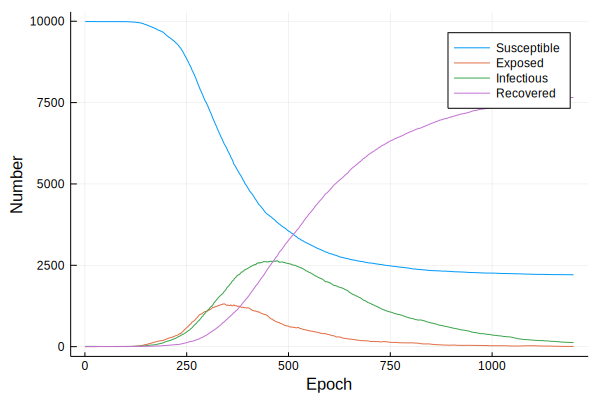

In [12]:
plot(susceptible, label="Susceptible")
plot!(exposed, label="Exposed")
plot!(infectious, label="Infectious")
plot!(recovered, label="Recovered",xlabel="Epoch",ylabel="Number")

#### get PRC and ROC curves for simulation at the point it was stopped
(eg, if you want it at 300 epochs, you need to stop the simulation at 300 epochs)

To re-start from zero, execute starting from `make_structures`, to reset all fields. We run up until epoch 250 to plot PRC and AUC for the probability calculation at an early stage of the epidemic.

In [13]:
contactlist,probabilities,probabilities_naive, infected = make_structures(NNodes, true);
for n in 1:10
    m = rand(1:NNodes)
    if length(probabilities)>0
        probabilities[m] = 1.0
    end
    probabilities_naive[m] = 1.0
    infected[m]=1;
end
epoch = 1
for n = 1:250
    epoch = sweep(links,contactlist, probabilities,probabilities_naive,
            infected, 0.001, p_t, epoch, 50, p_r,p_e,0,0.0,1.0,0.0,0.1)
end


In [14]:
function get_prec_recall(probabilities,infected)
    prec = []
    rec = []
    for pn in 1:100
        p = pn/100
        tp = 0
        fp = 0
        fn = 0
        tn = 0
        for n in 1:length(probabilities)
            if probabilities[n] >= p 
                if infected[n] >0
                    tp += 1
                else
                    fp += 1
                end
            elseif infected[n] >0
                fn += 1
            else
                tn += 1
            end
        end
        push!(rec,tp/(tp+fn))
        push!(prec,tp/(tp+fp))
    end
    return prec,rec
end
                

get_prec_recall (generic function with 1 method)

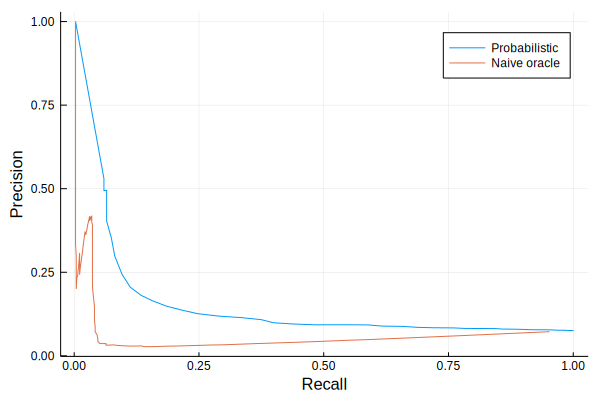

In [15]:
prec,rec = get_prec_recall(probabilities,infected);
precn, recn = get_prec_recall(probabilities_naive,infected);
plot(rec,prec, label="Probabilistic")
plot!(recn,precn, label="Naive oracle", xaxis="Recall",yaxis="Precision")


In [16]:
function get_roc(probabilities,infected)
    tpr = []
    fpr = []
    for pn in 1:100
        p = pn/100
        tp = 0
        fp = 0
        fn = 0
        tn = 0
        for n in 1:length(probabilities)
            if probabilities[n] >= p 
                if infected[n] > 0
                    tp += 1
                else
                    fp += 1
                end
            elseif infected[n] > 0
                fn += 1
            else
                tn += 1
            end
        end
        push!(tpr,tp/(tp+fn))
        push!(fpr,fp/(fp+tn))
    end
    return tpr,fpr
end
                

get_roc (generic function with 1 method)

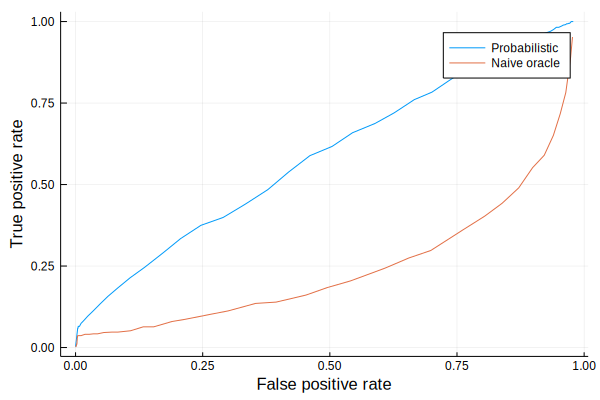

In [17]:
tpr,fpr = get_roc(probabilities,infected);
tprn, fprn = get_roc(probabilities_naive,infected);
plot(fpr,tpr, label="Probabilistic")
plot!(fprn,tprn, label="Naive oracle", xaxis="False positive rate",yaxis="True positive rate")


#### Testing and isolation
Same simulation as previously, but set `test_threshold` to 0.8, `test_fraction` to 0.1, `isolate_factor` to 0.1

In [18]:
contactlist,probabilities,probabilities_naive, infected = make_structures(NNodes, true);
for n in 1:10
    m = rand(1:NNodes)
    if length(probabilities)>0
        probabilities[m] = 1.0
    end
    probabilities_naive[m] = 1.0
    infected[m]=1;
end
epoch = 1
susceptible = []
exposed = []
infectious = []
recovered = []
for n = 1:1200
    epoch = sweep(links,contactlist, probabilities,probabilities_naive,
            infected, 0.001, p_t, epoch, 50, p_r,p_e,0,0.0,0.9,0.1,0.1)
    push!(susceptible,length([x for x in infected if x==0]))
    push!(exposed, length([x for x in infected if x<= -2]))
    push!(infectious, length([x for x in infected if x>0]))
    push!(recovered, length([x for x in infected if x== -1]))
end


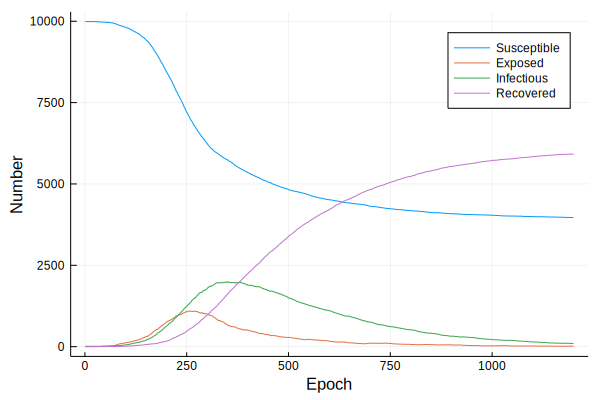

In [19]:
plot(susceptible, label="Susceptible")
plot!(exposed, label="Exposed")
plot!(infectious, label="Infectious")
plot!(recovered, label="Recovered",xlabel="Epoch",ylabel="Number")